# Fluorence of a two-level atom

### installing & loading packages

In [ ]:
using Pkg

Pkg.add("QuantumOptics")
Pkg.add("CairoMakie")
Pkg.add("LaTeXStrings")
Pkg.add("LinearAlgebra")
Pkg.add("FFTW")
Pkg.add("Plots")
# Pkg.update()

In [1]:
using QuantumOptics
using CairoMakie
using LaTeXStrings
using LinearAlgebra
using FFTW

import Plots as P
colors=P.palette(:tab10)

## 1) Finding the steady-state

We first define the usefull quantites and the Hamiltonian
$$
H=-\frac{\hbar\delta}{2}\sigma_z +\frac{\hbar\Omega}{2}(\sigma_+ + \sigma_-),
$$
where $ \hbar \omega_0$ is the energy betewen de ground and the excited state , $\omega_l$ is the laser frequency, $\delta =\omega_L - \omega_0$ is the detuning and $\Omega$ the Rabi frenquency.
For computational reason, we will set $\hbar=1$.

In [161]:
#basis
b = NLevelBasis(2)

#parameters
ω_L=1
ω_0=1
Ωs=[0,0.1, 1, 10]
δ=ω_L - ω_0

Γe=1

#Hamiltonian
σ_p=transition(b,2,1)
σ_m=transition(b,1,2)
σ_z=transition(b,2,2) - transition(b,1,1)

H(δ, Ω)=-(δ/2)*σ_z + (Ω/2)*(σ_p + σ_m)

#jump operators
J=[σ_m]

#rates  
# rates=[Γe]

1-element Vector{Operator{NLevelBasis{Int64}, NLevelBasis{Int64}, SparseArrays.SparseMatrixCSC{ComplexF64, Int64}}}:
 Operator(dim=2x2)
  basis: NLevel(N=2)
      ⋅       1.0 + 0.0im
      ⋅            ⋅     

In [4]:
#initial state
ψ0 = (nlevelstate(b,2)+nlevelstate(b,1))/ sqrt(2)
# ψ0 = nlevelstate(b, 1)  # excited state
# ρ0=tensor(ψ0,ψ0')

#time evolution
tspan = 0:0.05:10

#plot + computation
fig = Figure()
ax = Axis(fig[1, 1], xlabel=L"t", ylabel="excited state population")

for (i,Ω) in enumerate(Ωs)
    #time evolution
    tout, ψt=timeevolution.master(tspan,ψ0,H(δ, Ω),J,rates=rates)
    #expectation value
    exp_pt=real(expect(transition(b,2,2),ψt))
    #plotting
    lines!(ax, tspan, exp_pt, label=L"\Omega/\Gamma_e = %$(Ω/Γe)",color=colors[i])
end

axislegend(ax,position=:rb)
fig

UndefVarError: UndefVarError: `rates` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

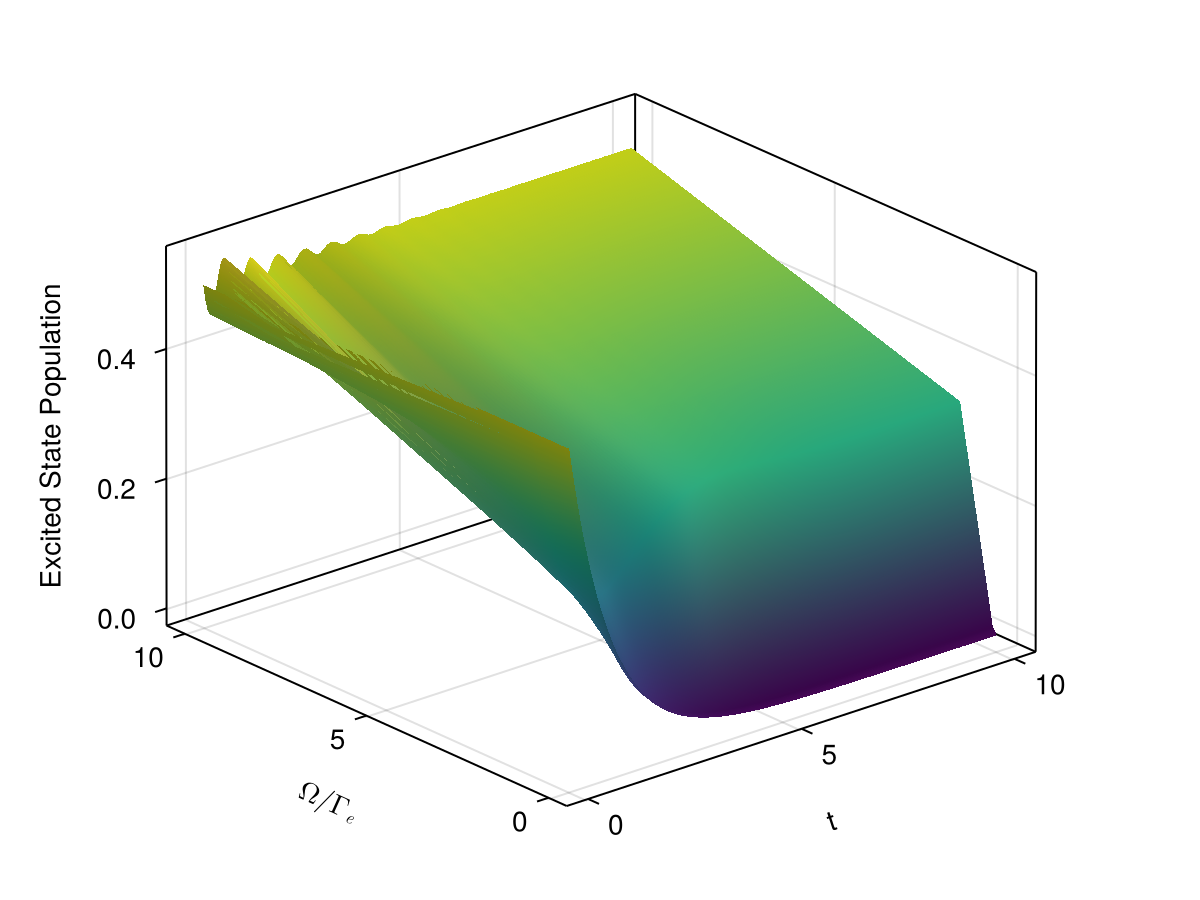

In [7]:
#using GLMakie

tspan = 0:0.05:10
T = collect(tspan)
Ω_vals = Ωs
Z = zeros(length(T), length(Ω_vals))  # store expectation values

for (j, Ω) in enumerate(Ω_vals)
    # Time evolution
    _, ψt = timeevolution.master(tspan, ψ0, H(δ, Ω), J, rates=rates)
    
    Z[:, j] .= real(expect(transition(b, 2, 2), ψt))
end

time_grid = repeat(T, 1, length(Ω_vals))
Ω_grid = repeat(reshape(Ω_vals, 1, :), length(T), 1)

fig = Figure()
ax = Axis3(fig[1, 1], xlabel="t", ylabel=L"\Omega/\Gamma_e", zlabel="Excited State Population")

surface!(ax, time_grid, Ω_grid ./ Γe, Z, colormap=:viridis)

fig

## Computing the steady state and finding the number of fluorescence cycle per second for differents $\delta$

The numbre of fluorescence cycle per second is $R=\Gamma_e \langle P_e \rangle_{\rho_{ss}}$ with $P_e= \ket{e}\bra{e}$ the population of the excited state.

In [8]:

Ωs=0:0.01:10
δs=[0,0.1,1,5,10]

fig = Figure()
ax = Axis(fig[1, 1], xlabel=L"\Omega/\Gamma_e", ylabel="R",title="Fluorescence cycles per second")
for (j,δ) in enumerate(δs)
    cycles=[]
    cycles_std=[]
    for (i,Ω) in enumerate(Ωs)
        tout, ρ_master = steadystate.master(H(δ,Ω), J)
        push!(cycles,real(expect(transition(b,2,2),ρ_master[end]))*rates[1])
        push!(cycles_std,real(variance(transition(b,2,2),ρ_master[end]))*rates[1])
    end
    lines!(ax, Ωs, cycles, label=L"\delta=%$δ",color=colors[j])
    #error bars
    band!(ax, Ωs, cycles .- cycles_std, cycles .+ cycles_std, color=colors[j], alpha=0.2)
end
Legend(fig[1,2],ax)
display(fig)

ErrorException: `Makie.convert_arguments` for the plot type Lines and its conversion trait PointBased() was unsuccessful.

The signature that could not be converted was:
::Vector{Float32}, ::Vector{Any}

Makie needs to convert all plot input arguments to types that can be consumed by the backends (typically Arrays with Float32 elements).
You can define a method for `Makie.convert_arguments` (a type recipe) for these types or their supertypes to make this set of arguments convertible (See http://docs.makie.org/stable/documentation/recipes/index.html).

Alternatively, you can define `Makie.convert_single_argument` for single arguments which have types that are unknown to Makie but which can be converted to known types and fed back to the conversion pipeline.


# 2) Fluorescence spectrum

## 2.1) Two-time correlation function $\langle \sigma_+(\tau)\sigma_-(0)\rangle$ for a resonant driving

In [5]:
#first we find the steady state
Ω=10
δ=0
tout, ρ_master = steadystate.master(H(δ,Ω), J)
#then we define A(0)
A0=σ_m*ρ_master[end]
#and we compute the time evolution
τspan = 0:0.05:10
tout, At= timeevolution.master(τspan,A0,H(δ,Ω),J,rates=rates)
#expectation value
exp_At=zeros(length(At))
for i in 1:length(At)
    exp_At[i]=real(tr(σ_p*At[i]))
end
#plotting
fig = Figure()
ax = Axis(fig[1, 1], xlabel=L"\tau", ylabel=L"\langle \sigma_+(\tau)\sigma_-(0)\rangle")
lines!(ax, τspan, exp_At, label=L"\Omega/\Gamma_e = %$(Ω/Γe)",color=colors[1])
axislegend(ax,position=:rb)
fig

UndefVarError: UndefVarError: `colors` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## 2.2) Fourrier transform

# Temperature effects

In [6]:
#basis
b = NLevelBasis(2)

#parameters
ω_L=1
ω_0=1
Ωs=[0,0.1, 1, 10]
δ=ω_L - ω_0

# ħ = 1.054571817e-34
# kB = 1.380649e-23

Γe=1
#temparature

n(α)=1 / (exp(α) - 1)

#Hamiltonian
σ_p=transition(b,2,1)
σ_m=transition(b,1,2)
σ_z=transition(b,2,2) - transition(b,1,1)

H(δ, Ω)=-(δ/2)*σ_z + (Ω/2)*(σ_p + σ_m)

#jump operators
J=[σ_m,σ_p]

#rates  
rates(T)=[Γe*(1 + n(T)), Γe*n(T)]

ErrorException: cannot define function rates; it already has a value

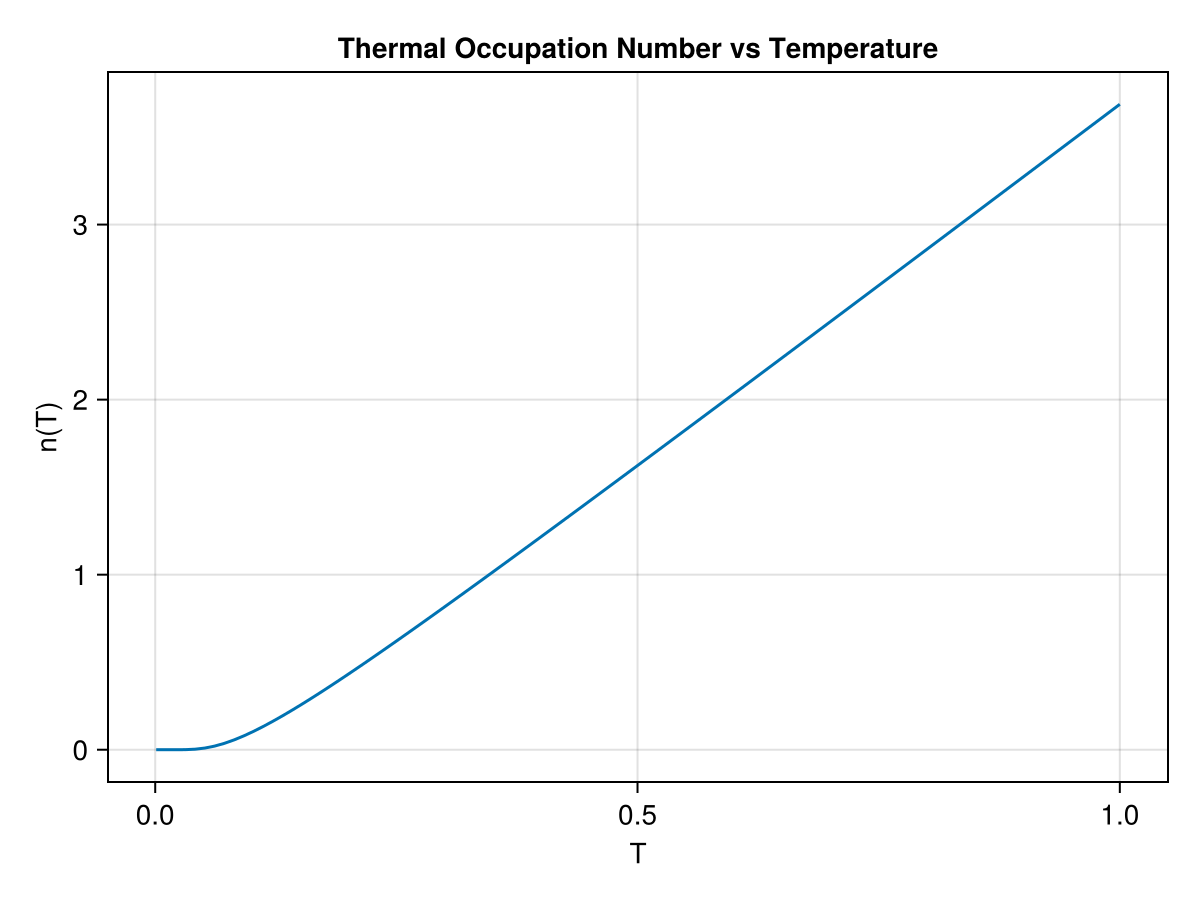

In [13]:
Ts = range(0.001, 1, length=100)
n_vals = [n(T) for T in Ts]

fig = Figure()
ax = Axis(fig[1, 1], xlabel="T", ylabel="n(T)", title="Thermal Occupation Number vs Temperature")
lines!(ax, Ts, n_vals)
fig

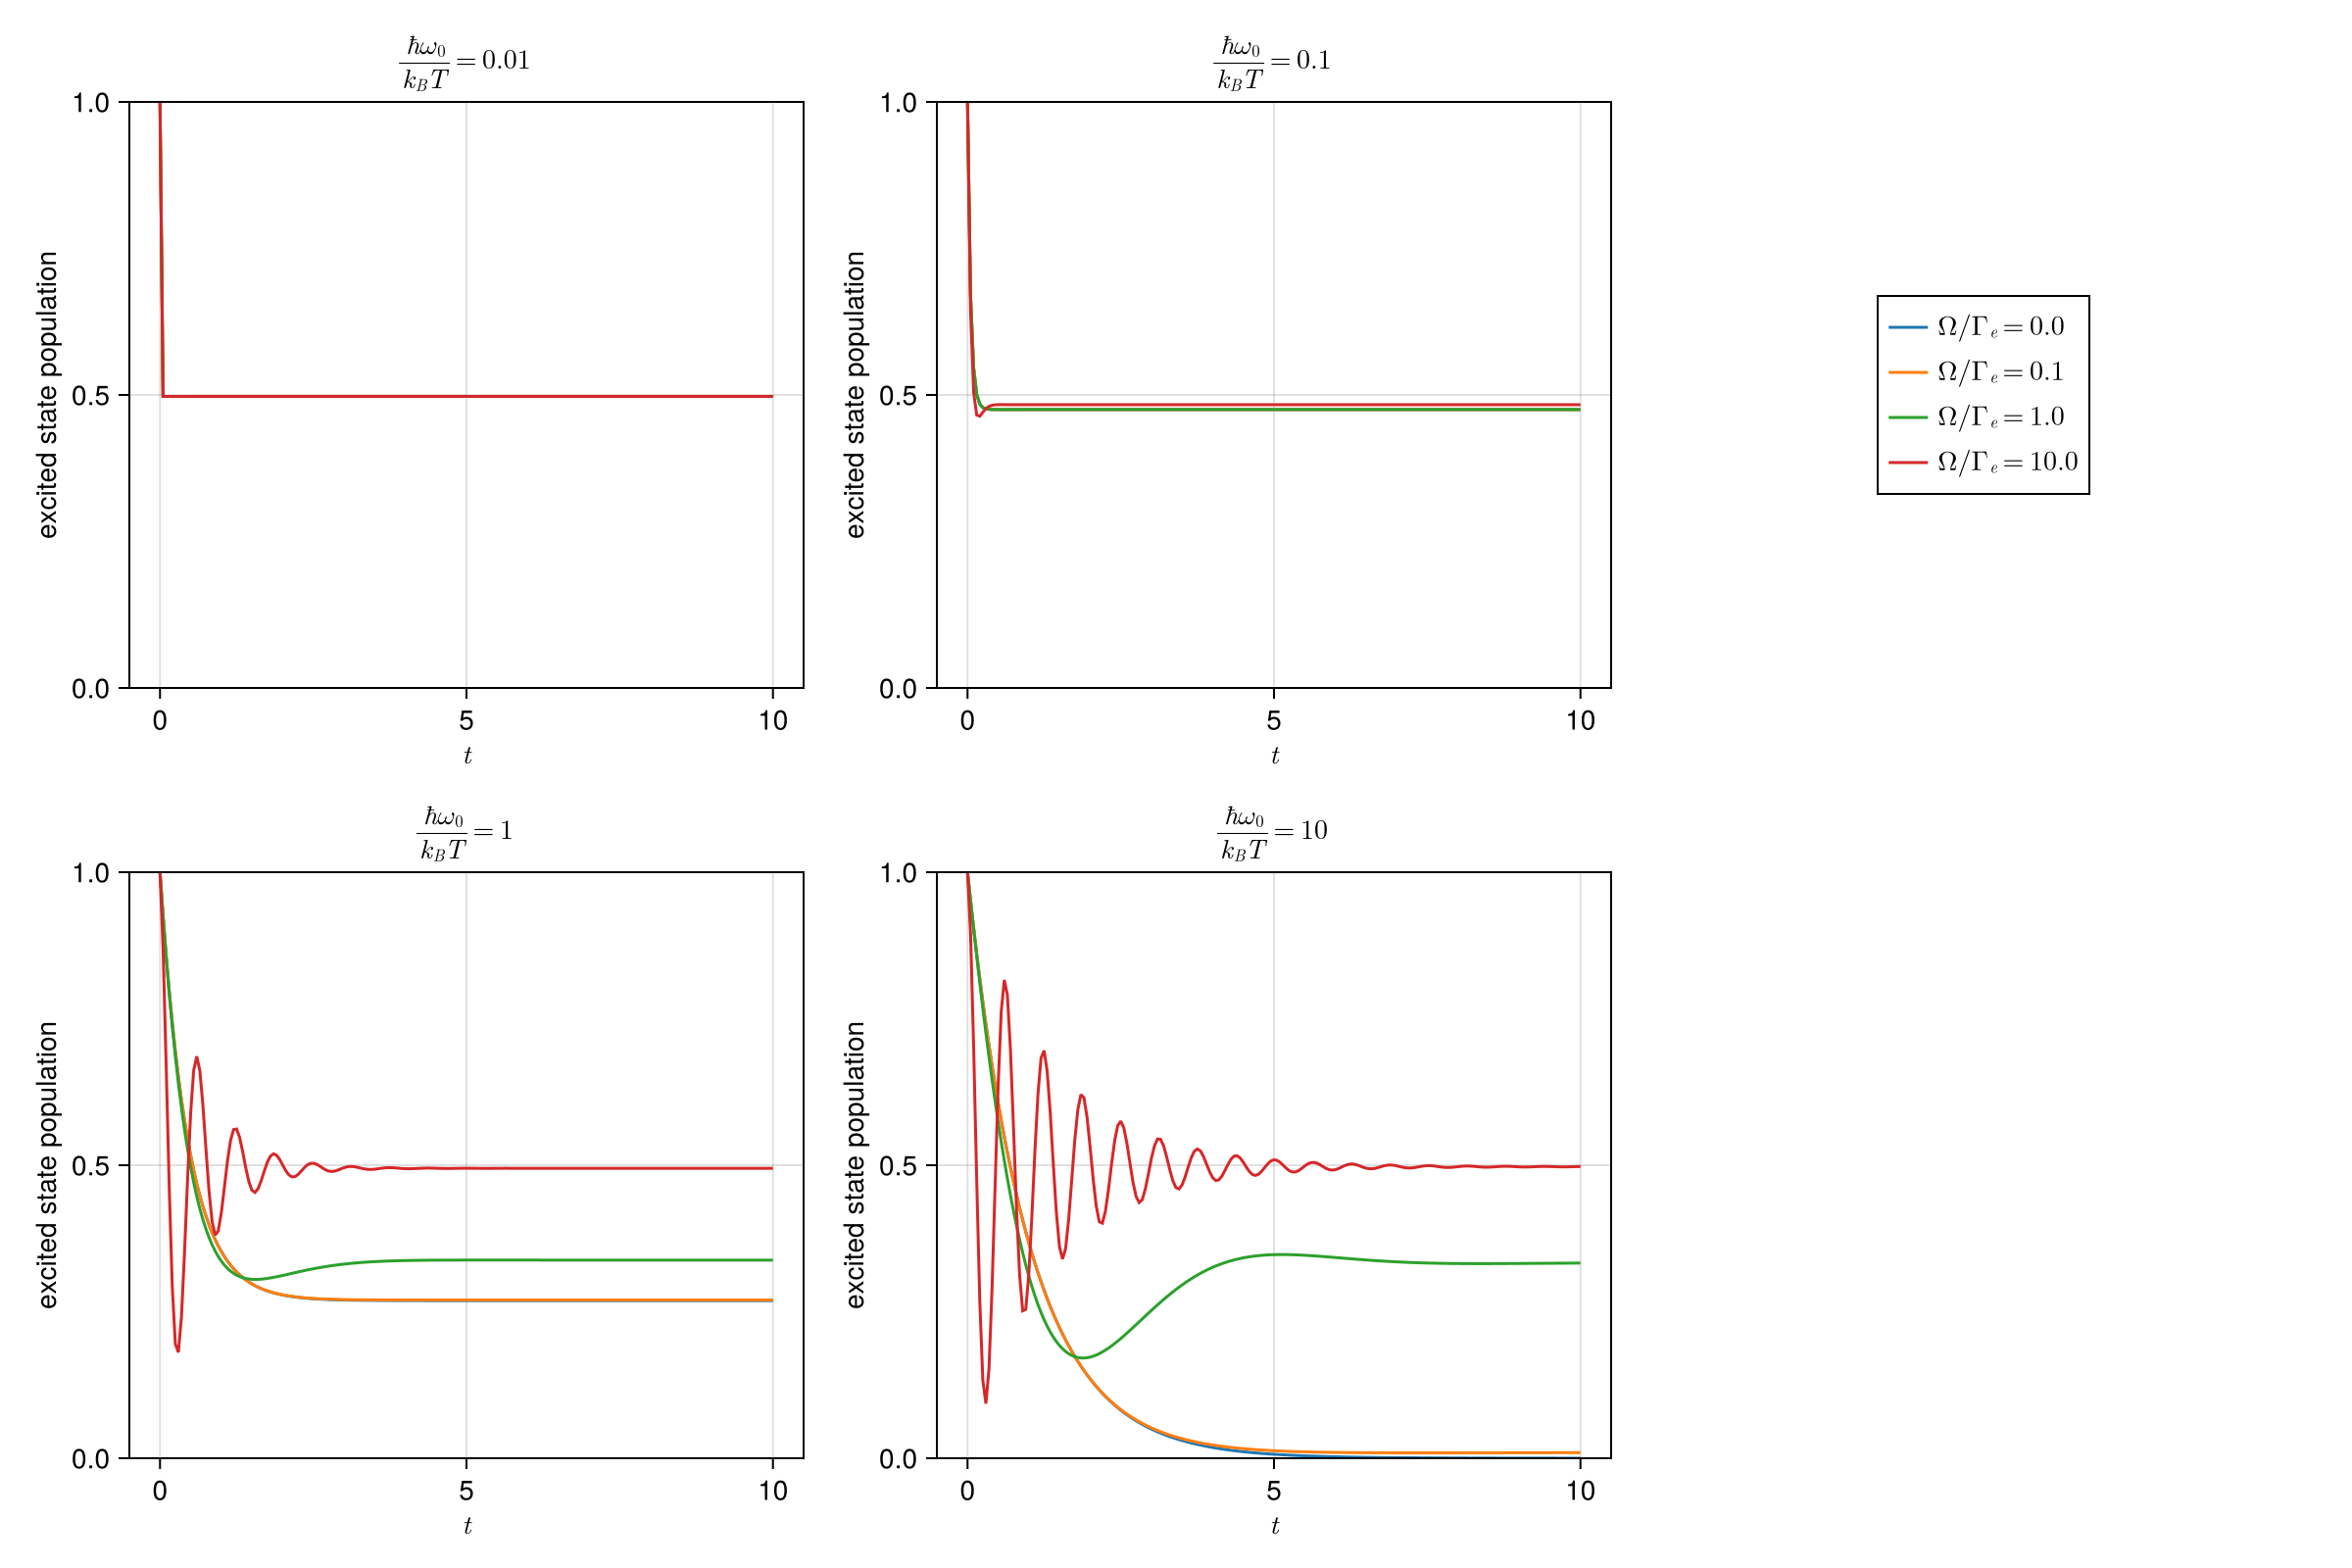

In [46]:
#initial state
ψ0 = nlevelstate(b,2)
# ρ0=tensor(ψ0,ψ0')

#time evolution
tspan = 0:0.05:10
αs=[0.01, 0.1, 1, 10]
#plot + computation
fig = Figure(size=(1200, 800), layout=(2, 3))

ax1 = Axis(fig[1,1], xlabel=L"t", ylabel="excited state population",title=L"\frac{\hbar \omega_0}{k_B T}= 0.01")
ax2 = Axis(fig[1,2], xlabel=L"t", ylabel="excited state population",title=L"\frac{\hbar \omega_0}{k_B T}= 0.1")
ax3 = Axis(fig[2,1], xlabel=L"t", ylabel="excited state population",title=L"\frac{\hbar \omega_0}{k_B T}= 1")
ax4 = Axis(fig[2,2], xlabel=L"t", ylabel="excited state population",title=L"\frac{\hbar \omega_0}{k_B T}= 10")
axs = [ax1, ax2, ax3, ax4]
for ax in axs
    ylims!(ax, 0, 1)
end

for (j,α) in enumerate(αs)
    for (i,Ω) in enumerate(Ωs)
        #time evolution
        tout, ψt=timeevolution.master(tspan,ψ0,H(δ, Ω),J,rates=rates(α))
        #expectation value
        exp_pt=real(expect(transition(b,2,2),ψt))
        #plotting
        lines!(axs[j], tspan, exp_pt, label=L"\Omega/\Gamma_e = %$(Ω/Γe)",color=colors[i])
    end
    if j%2==0
        a=1
    end
end

Legend(fig[1,3],ax,tellwidth=false)

fig

In [7]:
τs = 0:0.05:10 #List of τ


fig = Figure(size=(1200, 800), layout=(2, 3))
ax1 = Axis(fig[1, 1], xlabel=L"τ", ylabel=L"\langle \sigma_+(\tau)\sigma_-(0)\rangle_{ss}",title=L"\frac{\hbar \omega_0}{k_B T}= 0.01")
ax2 = Axis(fig[1, 2], xlabel=L"τ", ylabel=L"\langle \sigma_+(\tau)\sigma_-(0)\rangle_{ss}",title=L"\frac{\hbar \omega_0}{k_B T}= 0.1")
ax3 = Axis(fig[2, 1], xlabel=L"τ", ylabel=L"\langle \sigma_+(\tau)\sigma_-(0)\rangle_{ss}",title=L"\frac{\hbar \omega_0}{k_B T}= 1")
ax4 = Axis(fig[2, 2], xlabel=L"τ", ylabel=L"\langle \sigma_+(\tau)\sigma_-(0)\rangle_{ss}",title=L"\frac{\hbar \omega_0}{k_B T}= 10")
axs = [ax1, ax2, ax3, ax4]
# for ax in axs
#     ylims!(ax, 0, 0.5)
# end

for (j,α) in enumerate(αs)
    for (i,Ω) in enumerate(Ωs)
        #steady state
        ρ0 = steadystate.eigenvector(H(δ,Ω), J; rates = rates(α))
        #correlation function
        corr = timecorrelations.correlation(τs, ρ0, H(δ,Ω), J, σ_p, σ_m; rates = rates(α))
        #plotting
        lines!(axs[j], τs, real(corr), label=L"\Omega/\Gamma_e = %$(Ω/Γe)",color=colors[i])
    end
end

Legend(fig[1,3],ax1,tellwidth=false)
fig

ErrorException: cannot define function rates; it already has a value

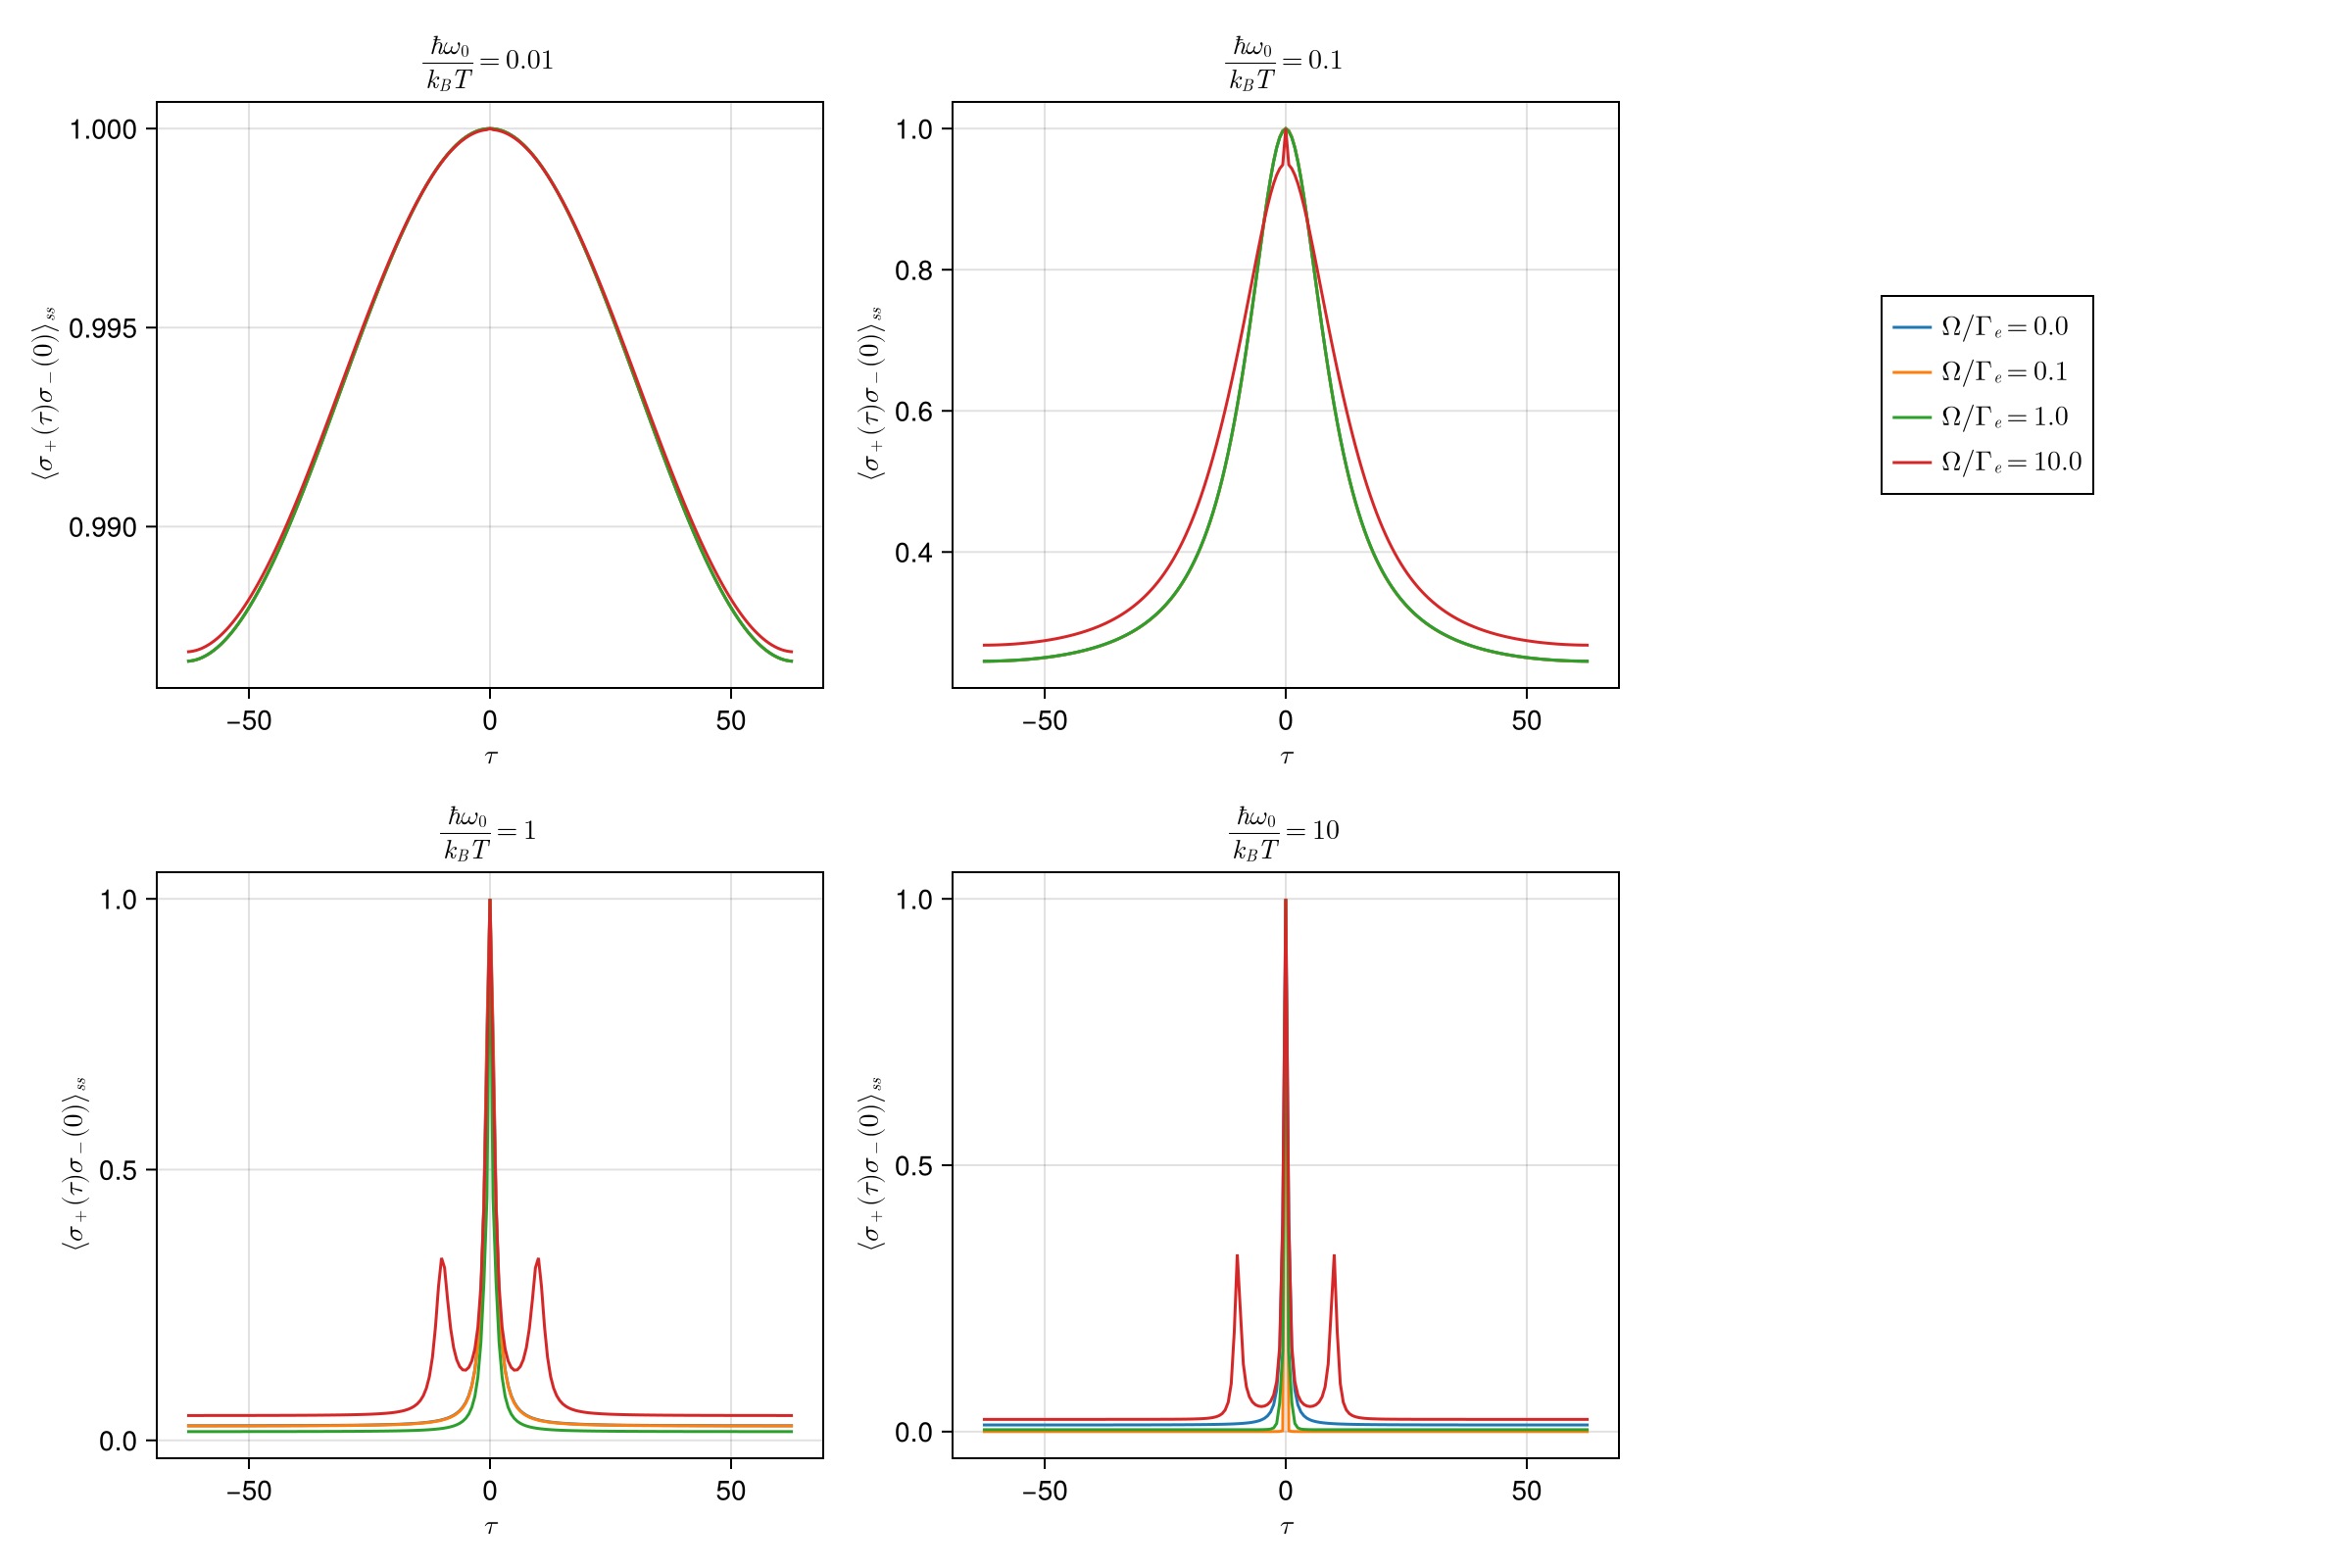

In [8]:
τs = 0:0.05:10 #List of τ
αs=[0.01, 0.1, 1, 10]

n(α)=1 / (exp(α) - 1)
rates(T)=[Γe*(1 + n(T)), Γe*n(T)]
#jump operators
J=[σ_m,σ_p]

fig = Figure(size=(1200, 800), layout=(2, 3))
ax1 = Axis(fig[1, 1], xlabel=L"τ", ylabel=L"\langle \sigma_+(\tau)\sigma_-(0)\rangle_{ss}",title=L"\frac{\hbar \omega_0}{k_B T}= 0.01")
ax2 = Axis(fig[1, 2], xlabel=L"τ", ylabel=L"\langle \sigma_+(\tau)\sigma_-(0)\rangle_{ss}",title=L"\frac{\hbar \omega_0}{k_B T}= 0.1")
ax3 = Axis(fig[2, 1], xlabel=L"τ", ylabel=L"\langle \sigma_+(\tau)\sigma_-(0)\rangle_{ss}",title=L"\frac{\hbar \omega_0}{k_B T}= 1")
ax4 = Axis(fig[2, 2], xlabel=L"τ", ylabel=L"\langle \sigma_+(\tau)\sigma_-(0)\rangle_{ss}",title=L"\frac{\hbar \omega_0}{k_B T}= 10")
axs = [ax1, ax2, ax3, ax4]
# for ax in axs
#     ylims!(ax, 0, 0.5)
# end

for (j,α) in enumerate(αs)
    for (i,Ω) in enumerate(Ωs)
        #steady state
        ρ0 = steadystate.eigenvector(H(δ,Ω), J; rates = rates(α))
        #correlation function
        corr = timecorrelations.correlation(τs, ρ0, H(δ,Ω), J, σ_p, σ_m; rates = rates(α))
        ω, spec=timecorrelations.correlation2spectrum(τs, corr,normalize_spec=true)
        lines!(axs[j], ω, real(spec), label=L"\Omega/\Gamma_e = %$(Ω/Γe)",color=colors[i])
    end
end

Legend(fig[1,3],ax1,tellwidth=false)
fig

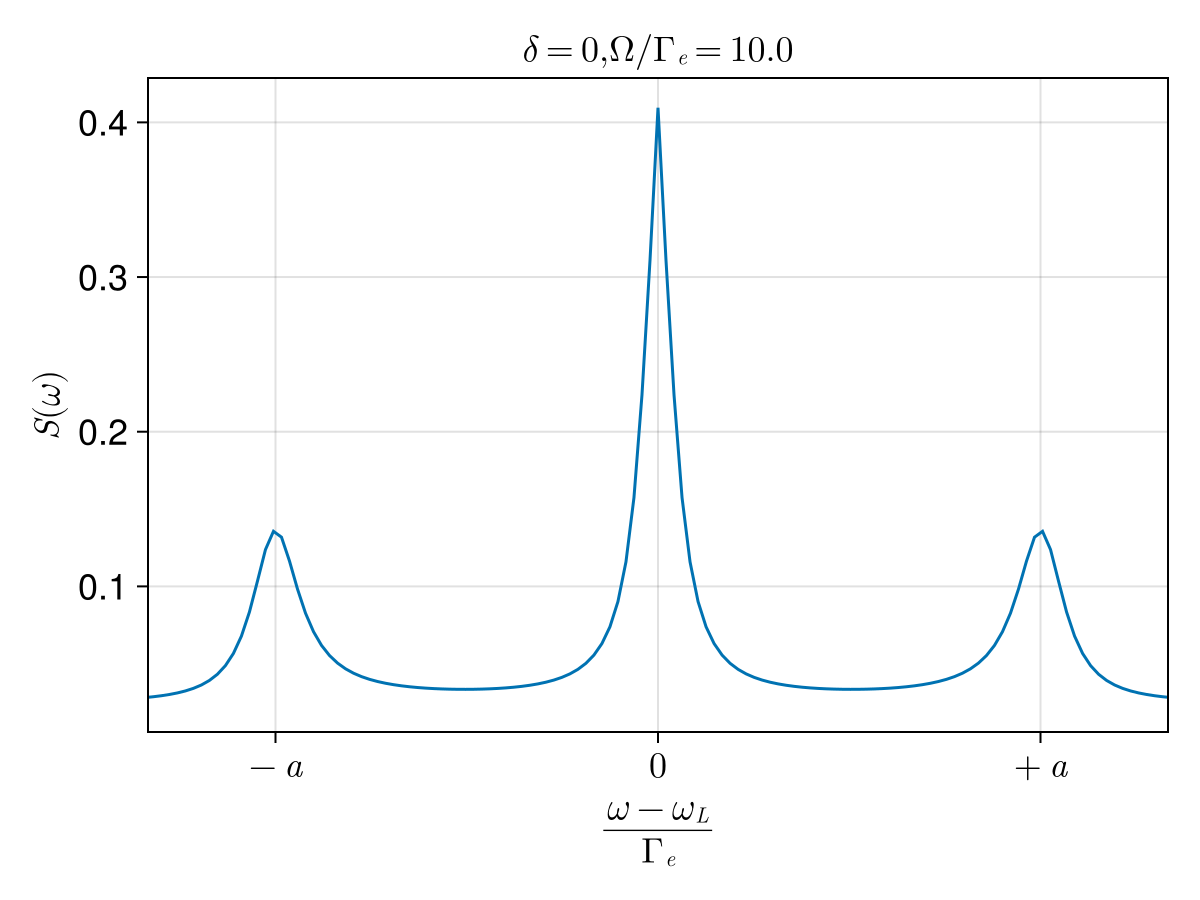

In [97]:
τs = 0:0.05:10 #List of τ
#basis
b = NLevelBasis(2)

#parameters
ω_L=1
ω_0=1


#Hamiltonian
σ_p=transition(b,2,1)
σ_m=transition(b,1,2)
σ_z=transition(b,2,2) - transition(b,1,1)

H(δ, Ω)=-(δ/2)*σ_z + (Ω/2)*(σ_p + σ_m)

#jump operators
J=[σ_m,σ_z]

Ω=30
δ=0
Γe=3
Γd=0
tmp=sqrt(δ^2+Ω^2)

xts=([-tmp,0.0,+tmp],[L"-a", L"0", L"+a"])

fig= Figure(fontsize=18)
ax= Axis(fig[1, 1],
        xlabel=L"\frac{\omega-\omega_L}{\Gamma_e}", 
        ylabel=L"S(\omega)",
        title=L"\delta = %$(δ), \Omega/\Gamma_e = %$(Ω/Γe)",
        xticks=xts
)
xlims!(ax, (-tmp-10, tmp+10))
ρ0 = steadystate.eigenvector(H(δ,Ω), J; rates = [Γe, Γd])
#correlation function
corr = timecorrelations.correlation(τs, ρ0, H(δ,Ω), J, σ_p, σ_m; rates = [Γe, Γd])
ω, spec=timecorrelations.correlation2spectrum(τs, corr)
lines!(ax, ω, real(spec))
# hlines!(ax,[maximum(spec)/3], color=:black, linestyle=:dash)
# axislegend(ax, position=:rb)
save("spectrum2.png", fig)
fig

## Mollow Triplet - Detuning effect

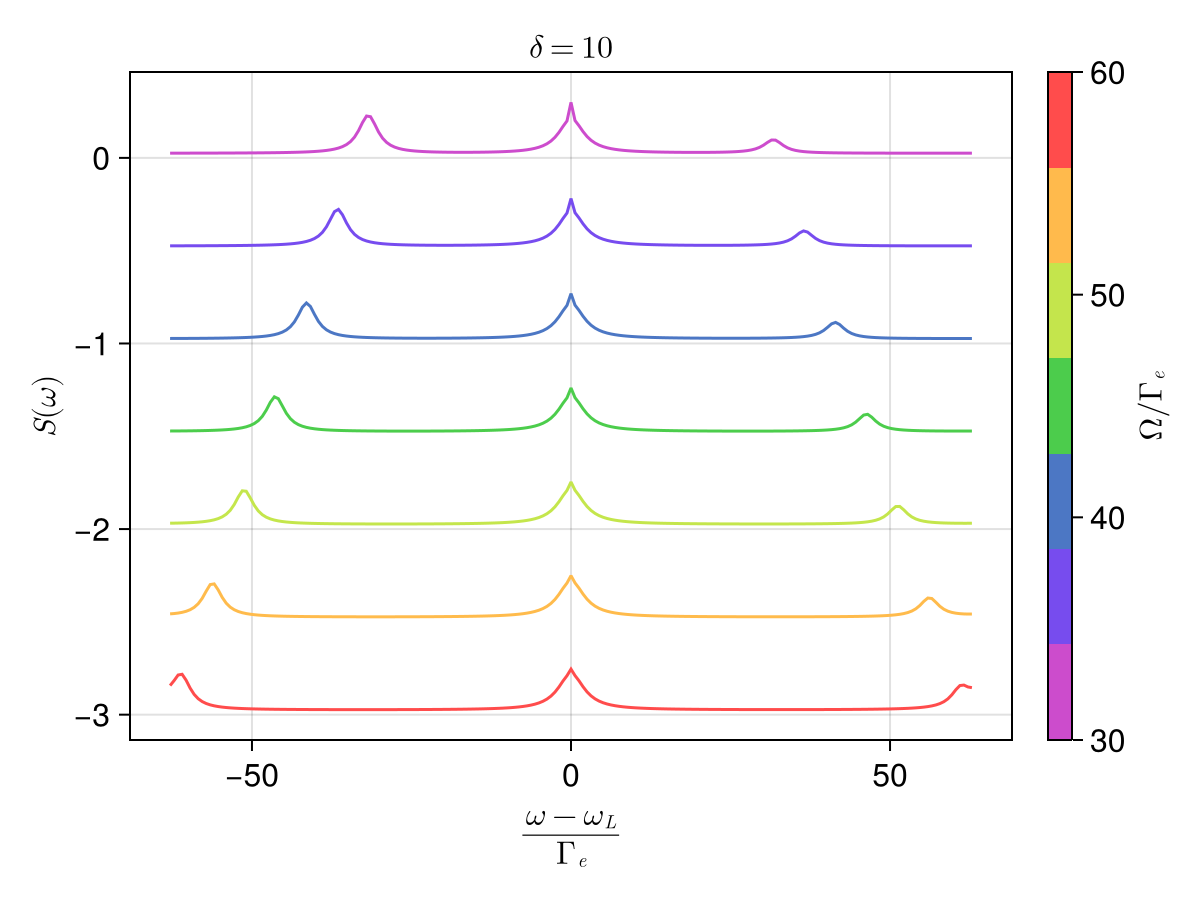

In [94]:
τs = 0:0.05:10 #List of τ


#basis
b = NLevelBasis(2)

#parameters
ω_L=1
ω_0=1
# Ω=20

#Hamiltonian
σ_p=transition(b,2,1)
σ_m=transition(b,1,2)
σ_z=transition(b,2,2) - transition(b,1,1)

H(δ, Ω)=-(δ/2)*σ_z + (Ω/2)*(σ_p + σ_m)

#jump operators
J=[σ_m,σ_z]


Ωs=30:5:60
colors=cgrad(:lightrainbow, length(Ωs), categorical = true)
Γe=1
Γd=1
δ=10
fig= Figure(fontsize=16)
ax= Axis(fig[1, 1], xlabel=L"\frac{\omega-\omega_L}{\Gamma_e}", ylabel=L"S(\omega)",title=L"\delta = %$(δ)")
for (i, Ω) in enumerate(Ωs)
    ρ0 = steadystate.eigenvector(H(δ,Ω), J; rates = [Γe, Γd])
    corr = timecorrelations.correlation(τs, ρ0, H(δ,Ω), J, σ_p, σ_m; rates = [Γe, Γd])
    ω, spec = timecorrelations.correlation2spectrum(τs, corr)
    offset = 0.5 * (i - 1)
    lines!(ax, ω, real(spec) .- offset, label=L"\Gamma_e/\Omega=%$(Ω/Γe)",color=colors[i])
    ω, spec = timecorrelations.correlation2spectrum(τs, corr)
    # lines!(ax, ω, real(spec), label=L"\Gamma_e=%$(Γe_vals)", color=colors[i])
    # println("Processed Γe = $Γe_val with color index ")
end
# hidespines!(ax)
# hidedecorations!(ax, grid = true)
Colorbar(fig[1,2], colormap=colors,limits=(minimum(Ωs)/Γe,maximum(Ωs)/Γe),label=L"\Omega/\Gamma_e")
# axislegend(ax, position=:rb)
save("mollow_triplet_Gamma5.png", fig)
fig

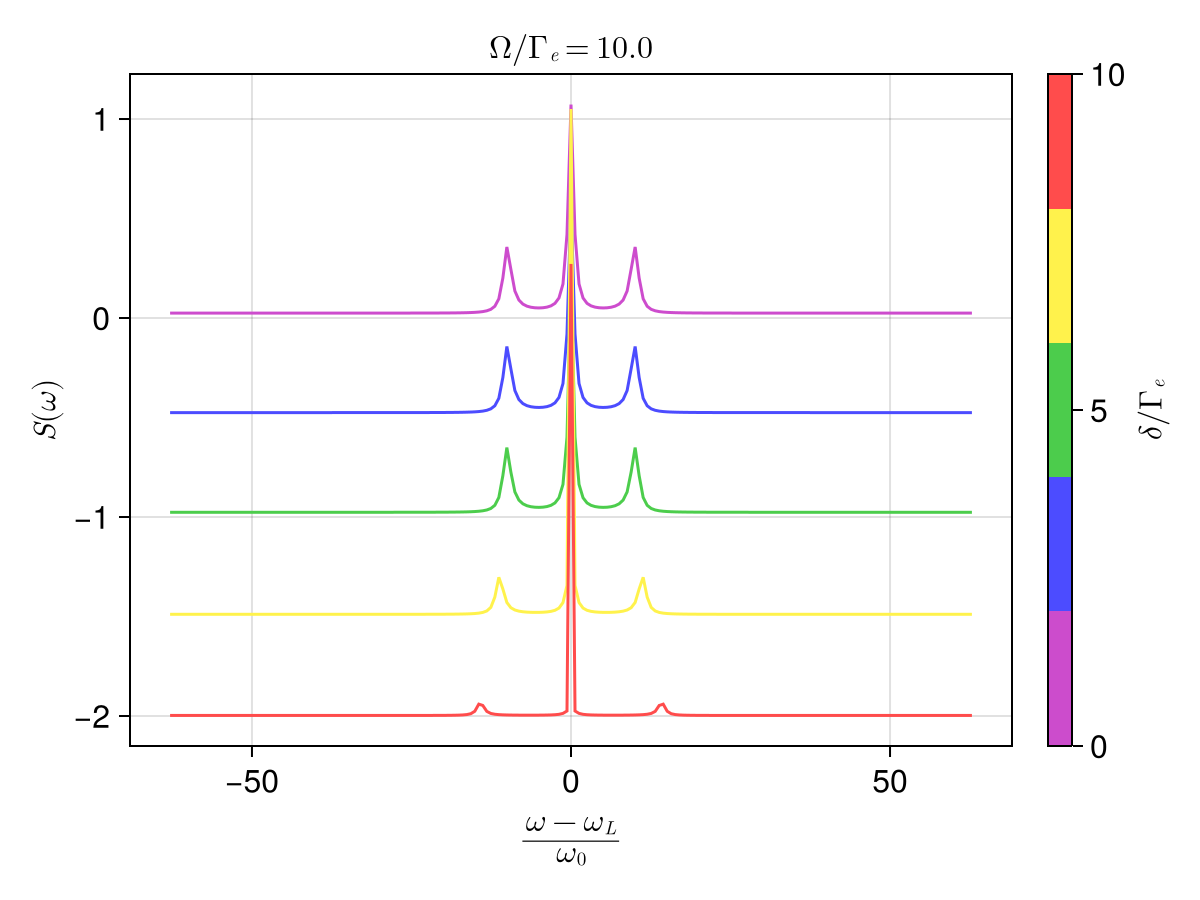

In [29]:
τs = 0:0.05:10 #List of τ


#basis
b = NLevelBasis(2)

#parameters
ω_L=1
ω_0=1
δ=0

Γe=1
Γd=0
# Ω=20

#Hamiltonian
σ_p=transition(b,2,1)
σ_m=transition(b,1,2)
σ_z=transition(b,2,2) - transition(b,1,1)

H(δ, Ω)=-(δ/2)*σ_z + (Ω/2)*(σ_p + σ_m)

#jump operators
J=[σ_m,σ_z]


Ω=10
δs=[0,0.1,1,5,10]
colors=cgrad(:lightrainbow, length(δs), categorical = true)
Γe=1
fig= Figure(fontsize=16)
ax= Axis(fig[1, 1], xlabel=L"\frac{\omega-\omega_L}{\Gamma_e}", ylabel=L"S(\omega)",title=L"\Omega/\Gamma_e = %$(Ω/Γe)")
for (i, δ) in enumerate(δs)
    ρ0 = steadystate.eigenvector(H(δ,Ω), J; rates = [Γe, Γd])
    corr = timecorrelations.correlation(τs, ρ0, H(δ,Ω), J, σ_p, σ_m; rates = [Γe, Γd])
    ω, spec = timecorrelations.correlation2spectrum(τs, corr)
    offset = 0.5 * (i - 1)
    lines!(ax, -ω, real(spec) .- offset, label=L"\delta/\Gamma_e=%$(δ/Γe)",color=colors[i])
    ω, spec = timecorrelations.correlation2spectrum(τs, corr)
    # lines!(ax, ω, real(spec), label=L"\Gamma_e=%$(Γe_vals)", color=colors[i])
    # println("Processed Γe = $Γe_val with color index ")
end
# hidespines!(ax)
# hidedecorations!(ax, grid = true)
Colorbar(fig[1,2], colormap=colors,limits=(minimum(δs)/Γe,maximum(δs)/Γe),label=L"\delta/\Gamma_e")
# axislegend(ax, position=:rb)
# save("mollow_triplet_Gamma2.png", fig)
fig